In [1]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import random
import matplotlib.pyplot as plt  # 画图

# 定义一个读取图片的函数readfile()


def readfile(path, label):
    # label 是一个布尔值，代表需不需要返回 y 值
    image_dir = sorted(os.listdir(path))
    # x存储图片，每张彩色图片都是128(高)*128(宽)*3(彩色三通道)
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    # y存储标签，每个y大小为1
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        # 利用cv2.resize()函数将不同大小的图片统一为128(高)*128(宽)
        x[i, :, :] = cv2.resize(img, (128, 128))
        if label:
            y[i] = int(file.split("_")[0]#得到第一个0前的内容
    if label:
        return x, y
    else:
        return x


# 分别将 training set、validation set、testing set 用函数 readfile() 读进来
workspace_dir = "./food-11"
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
val_x, val_y = readfile(os.path.join(workspace_dir, "validation"), True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(os.path.join(workspace_dir, "testing"), False)
print("Size of Testing data = {}".format(len(test_x)))

# training 时，通过随机旋转、水平翻转图片来进行数据增强（data augmentation）
train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),  # 随机翻转图片
        transforms.RandomRotation(15),  # 随机旋转图片
        transforms.ToTensor(),  # 将图片变成 Tensor，并且把数值normalize到[0,1]
    ]
)

# testing 时，不需要进行数据增强（data augmentation）
test_transform = transforms.Compose(
    [transforms.ToPILImage(), transforms.ToTensor(), ])


class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label 需要是 LongTensor 型
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X


# 定义残差块
class Residual_Block(nn.Module):
    def __init__(self, i_channel, o_channel, stride=1, down_sample=None):
        super(Residual_Block, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=i_channel,
            out_channels=o_channel,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        # BatchNorm2d(）对小批量3d数据组成的4d输入进行批标准化操作
        # 主要为了防止神经网络退化
        self.bn1 = nn.BatchNorm2d(o_channel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            in_channels=o_channel,
            out_channels=o_channel,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(o_channel)
        self.down_sample = down_sample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # 将单元的输入直接与单元输出加在一起
        if self.down_sample:
            residual = self.down_sample(x)  # 下采样
        out += residual
        out = self.relu(out)

        return out


# 定义残差神经网络
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=11):
        super(ResNet, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.in_channels = 16
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=0.5)  # dropout

    def make_layer(self, block, out_channels, blocks, stride=1):
        # blocks=layers,残差模块的数量
        down_sample = None
        # 判断是否in_channels(输入)与(输出)是否在同一维度
        # 即输入的3d数据的长宽高与输出的数据的长宽高是否一样
        if (stride != 1) or (self.in_channels != out_channels):
            # 如果不一样就转换一下维度
            down_sample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels,
                    kernel_size=3,
                    stride=stride,
                    padding=1,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, down_sample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)  # 添加所有残差块

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = self.dropout(out)  # dropout
        out = out.contiguous().view(out.size()[0], -1)
        out = self.fc(out)
        return out


# 更新学习率
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


# 固定随机种子
random.seed(1)
# 超参数设定
batch_size = 64
learning_rate = 1e-3

# 加载训练集、验证集
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

model = ResNet(Residual_Block, [2, 2, 2, 2]).cuda()
loss = nn.CrossEntropyLoss()  # 因为是分类任务，所以使用交叉熵损失

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # 使用Adam优化器
num_epoch = 100  # 迭代次数
early_stop = 5  # 如果 valid 上的 acc 5 次没有提升，就结束训练
patience = 0
best_valid_acc = 0.0


# 用测试集训练模型model(),用验证集作为测试集来验证
curr_lr = learning_rate
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train()  # 确保 model 是在 训练 model (开启 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()  # 用 optimizer 将模型参数的梯度 gradient 归零
        # 利用 model 得到预测的概率分布，这边实际上是调用模型的 forward 函数
        train_pred = model(data[0].cuda())
        batch_loss = loss(
            train_pred, data[1].cuda()
        )  # 计算 loss （注意 prediction 跟 label 必须同时在 CPU 或是 GPU 上）
        batch_loss.backward()  # 利用 back propagation 算出每个参数的 gradient
        optimizer.step()  # 以 optimizer 用 gradient 更新参数

        train_acc += np.sum(
            np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy()
        )
        train_loss += batch_loss.item()

    # 验证集val
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(
                np.argmax(val_pred.cpu().data.numpy(),
                          axis=1) == data[1].numpy()
            )
            val_loss += batch_loss.item()

        # 将结果 print 出來
        print(
            "[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f"
            % (
                epoch + 1,
                num_epoch,
                time.time() - epoch_start_time,
                train_acc / train_set.__len__(),
                train_loss / train_set.__len__(),
                val_acc / val_set.__len__(),
                val_loss / val_set.__len__(),
            )
        )

    # early stop & save best model
    patience += 1
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), os.path.join(
            workspace_dir, "best_model.pt"))
        patience = 0

    if patience >= early_stop:
        break

# 和 model 声明成一样的模型
model_best = ResNet(Residual_Block, [2, 2, 2, 2]).cuda()
model_best.load_state_dict(torch.load(
    os.path.join(workspace_dir, "best_model.pt")))


Reading data
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347
[001/100] 26.52 sec(s) Train Acc: 0.267484 Loss: 0.032704 | Val Acc: 0.345773 loss: 0.030091
[002/100] 22.90 sec(s) Train Acc: 0.362964 Loss: 0.028551 | Val Acc: 0.381050 loss: 0.027820
[003/100] 23.00 sec(s) Train Acc: 0.408778 Loss: 0.026750 | Val Acc: 0.322449 loss: 0.033404
[004/100] 25.15 sec(s) Train Acc: 0.436347 Loss: 0.025602 | Val Acc: 0.404665 loss: 0.026118
[005/100] 24.25 sec(s) Train Acc: 0.455402 Loss: 0.024600 | Val Acc: 0.457143 loss: 0.025447
[006/100] 23.41 sec(s) Train Acc: 0.479627 Loss: 0.023744 | Val Acc: 0.459767 loss: 0.024587
[007/100] 23.50 sec(s) Train Acc: 0.496655 Loss: 0.022781 | Val Acc: 0.432945 loss: 0.027078
[008/100] 23.61 sec(s) Train Acc: 0.515913 Loss: 0.021969 | Val Acc: 0.510204 loss: 0.022558
[009/100] 23.52 sec(s) Train Acc: 0.532131 Loss: 0.021420 | Val Acc: 0.502915 loss: 0.023404
[010/100] 23.86 sec(s) Train Acc: 0.547334 Loss: 0.020780 | Va

<All keys matched successfully>

In [2]:
model = model_best
model

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Residual_Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual_Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [3]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace


In [4]:
# 助教 training 时定义的 dataset
# 因为 training 的时候，助教使用底下那些 transforms，所以 testing 时也要让 test data 使用同样的 transform
# dataset 这部分 code 基本上不应该出现在你的作业里，你应该使用自己当初 train HW3 时的预处理 preprocessing
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        # mode: 'train' or 'eval'
        
        self.paths = paths
        self.labels = labels
        trainTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        evalTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
        ])
        self.transform = trainTransform if mode == 'train' else evalTransform

    # 这个 FoodDataset 继承了 pytorch 的 Dataset class
    # 而 __len__ 和 __getitem__ 是定义一个 pytorch dataset 时一定要重新定义的两个函数 method
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

    # 这个 method 并不是 pytorch dataset 必要的，只是方便未来我们想要指定取某张图片出来当作一个 batch 来可视化
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
          image, label = self.__getitem__(index)
          images.append(image)
          labels.append(label)
        return torch.stack(images), torch.tensor(labels)


In [5]:
args = {
      'ckptpath': './checkpoint.pth',
      'dataset_dir': './food-11/'
}
args = argparse.Namespace(**args)


In [6]:
# 输入 dataset 的 path，输出记录了每张图片的「路径」和「标签类别」的数组
def get_paths_labels(path):
    imgnames = os.listdir(path)
    imgnames.sort()
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    # 返回两个数组，imgpaths[0]是第0个图像的路径，labels[0]是第0个图像的标签
    return imgpaths, labels 
    
train_paths, train_labels = get_paths_labels(os.path.join(args.dataset_dir, 'training')) 
# 相当于 get_paths_labels('./food-11/training/')

# 这边在 initialize dataset 时只返回「路径」和「标签类别」，之后从 dataset 中取数据时
# dataset 的 __getitem__ 方法才会动态地去将路径对应的图像读入内存
train_set = FoodDataset(train_paths, train_labels, mode='eval')


In [7]:
# 标准化函数
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

def compute_saliency_maps(x, y, model):
  model.eval()
  x = x.cuda()

  # 最关键的一行代码
  # 因为我们要计算 loss 对 input image 的微分，原本 input x 只是一个 tensor，不需要 gradient
  # 现在我们明确告诉 pytorch 这个 input x 需要 gradient，这样 backward 后 x.grad 才会有微分值
  x.requires_grad_()
  
  y_pred = model(x) # 输入x，model forward 后得到预测值 y_pred
  loss_func = torch.nn.CrossEntropyLoss() # 损失函数是交叉熵损失
  loss = loss_func(y_pred, y.cuda()) # 计算预测值 y_pred 和实际标签值 y 的交叉熵损失 loss
  loss.backward() # 梯度反向传播

  saliencies = x.grad.abs().detach().cpu()
  # saliencies 的大小为: (batches, channels, height, weight)
  # 因为接下来我们要对每张图片作 saliency map，每张图片的 gradient scale 很可能有很大差异
  # 可能第一张图片的 gradient 在 100 ~ 1000，但第二张图片的 gradient 在 0.001 ~ 0.0001
  # 如果我们用同样的色阶去可视化每一张 saliency 的话，第一张可能全部都很亮，第二张全部都很暗，
  # 如此就看不到有意义的结果，我们想看的是「单张 saliency 内部的大小关系」，
  # 所以这边我們要对每张 saliency 分别作 normalize。normalize有很多方法，这里用最简单的
  saliencies = torch.stack([normalize(item) for item in saliencies])
  return saliencies


In [8]:


layer_activations = None
def filter_explaination(x, model, cnnid, filterid, iteration=100, lr=1):
  # x: 可视化的图片, cnnid, filterid: 指定第几层 cnn 中第几个 filter
  model.eval()

  def hook(model, input, output):
    global layer_activations
    layer_activations = output
  
  hook_handle = model.layer2[cnnid].conv2.register_forward_hook(hook)
  # 这一行告诉 pytorch，当 forward 「过了」第 cnnid 层 cnn 后，要先调用 hook() 这个我们定义的函数后才可以继续 forward 下一层 cnn
  # 因此上面的 hook() 函数中，我们就会把该层的 output，也就是 activation map 记录下来，这样 forward 完整个 model 后我们不只有 loss
  # 也有某层 cnn 的 activation map
  # 注意：到这行为止，都还没有发生任何 forward。我们只是先告诉 pytorch 等下真的要 forward 时该多做什么事
  # 注意：hook_handle 可以先跳过不用懂，等下看到后面就有说明了

  # Filter activation: 我们先观察 x 经过指定 filter 的 activation map
  model(x.cuda()) # 这行才是真正执行 forward，因为我们只需要 activation map，所以这里不存 loss 
  
  filter_activations = layer_activations[:, filterid, :, :].detach().cpu()
  # 根据 filterid 把特定 filter 的 activation map 取出來
  # 因为我们要画 activation map，所以可以直接 detach from graph 并存成 cpu tensor
  
  # Filter visualization: 找出可以最大程度激活该 filter 的图片
  x = x.cuda()
  # 从一张 random noise 的图片开始找 (也可以从一张 dataset image 开始找)
  x.requires_grad_()
  # 我们要对 input image 算偏微分
  optimizer = Adam([x], lr=lr)
  # 利用偏微分和 optimizer，逐步修改 input image 来让 filter activation 越来越大
  for iter in range(iteration):
    optimizer.zero_grad()
    model(x)
    
    objective = -layer_activations[:, filterid, :, :].sum()
    # 与 Sailency Map 不同，我们并不想知道 image 的微量变化会怎样影响 final loss
    # 我们想知道的是，image 的微量变化会怎样影响 activation 的程度
    # 因此 objective 是 filter activation 的综合，负号是因为优化目标是最小化 -objective， 即最大化 objective
    
    objective.backward()
    # 计算 filter activation 对 input image 的偏微分
    optimizer.step()
    # 修改 input image 来最大化 filter activation
  filter_visualization = x.detach().cpu().squeeze()[0]
  # 完成图片修改，只剩下要画出來，因此可以直接 detach 并转成 cpu tensor

  hook_handle.remove()
  # 很重要：一旦对 model register hook，该 hook 就一直存在。如果之后继续 register 更多 hook
  # 那 model 一次 forward 要做的事情就越来越多，甚至其行为模式会超出你预期 (因为你忘记哪个hook是用不到的)
  # 因此事情做完了之后，就把remove 这个 hook，下次需要时再 register 就好了。

  return filter_activations, filter_visualization


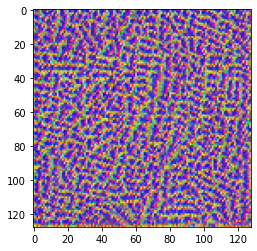

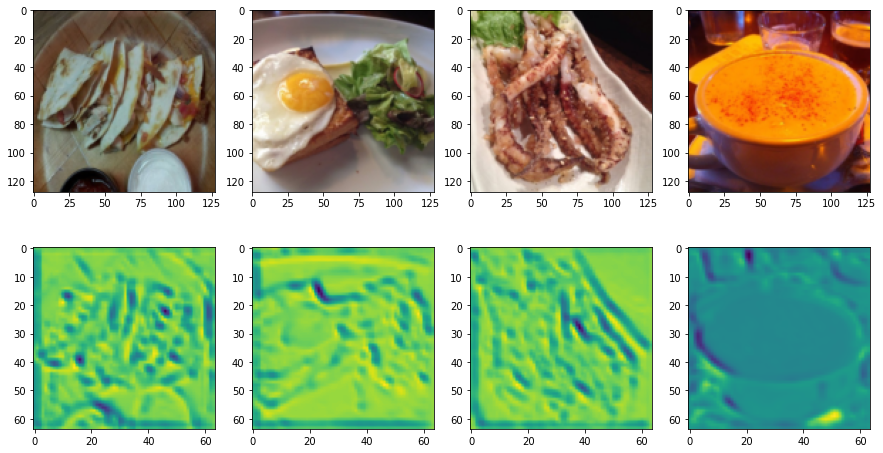

In [9]:
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualization = filter_explaination(images, model, cnnid=1, filterid=0, iteration=100, lr=0.1)

# 画出 filter visualization
plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
plt.show()
plt.close()

# 画出 filter activations
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
plt.show()
plt.close()


C:\Users\MNeilDiane\Anaconda3\envs\Augustine\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  if sys.path[0] == '':
100% |########################################################################|
C:\Users\MNeilDiane\Anaconda3\envs\Augustine\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  if sys.path[0] == '':
100% |########################################################################|
C:\Users\MNeilDiane\Anaconda3\envs\Augustine\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` paramet

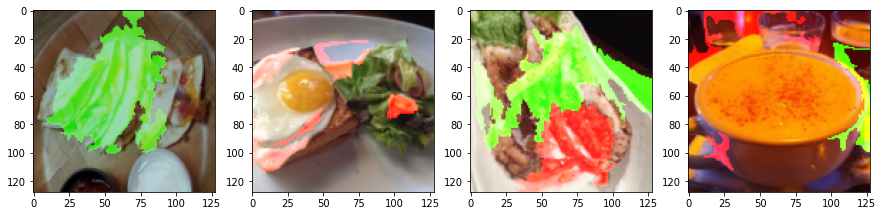

In [10]:
def predict(input): # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    model.eval()                                                                                                                                                             
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
    # 需要先将 input 转成 pytorch tensor，且符合 pytorch 习惯的 dimension 定义
    # 即 (batches, channels, height, width)

    output = model(input.cuda())                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):
    # 利用 skimage 提供的 segmentation 将图片分成 100 快                                                                                                                                  
    return slic(input, n_segments=100, compactness=1, sigma=1)                                                                                                              
                                                                                                                                                                             
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, 4, figsize=(15, 8))                                                                                                                                                                 
np.random.seed(16)    # 固定随机种子，让实验可以复现                                                                                                                                                   

for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):                                                                                                                                             
    x = image.astype(np.double) # lime 的输入是 numpy array

    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation,top_labels=11)
    # 基本上只要给 lime explainer 两个关键的 function，就结束啦
    # classifier_fn 定义图片如何经过模型得到 prediction
    # segmentation_fn 定义如何把图片分割为 segmentation
    # 可参考文档: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.05                                                                                                                              
                            )
    # 把 explainer 解释的结果转成图片
    # 可参考文档: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    
    axs[idx].imshow(lime_img)

plt.show()
plt.close()
